# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [ ]:
# Install libraries the first time
#! pip install -U yfinance pandas numpy matplotlib 

### Importing Required Libraries

In [43]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

### Variables

In [44]:
print_errors = False
build_new_dataset = False
symbols = 'simple' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'

## Data Preparation

In [45]:
if symbols == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbols == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['MATAS.CO', 'TRIFOR.CO', 'QQ.L', 'RNMBY', 'SAABF', 'BCKIY',
       'BAESY', 'IVSO.ST', 'NSKFF', 'GMAB', 'GN.CO', 'NVDA', 'LLY',
       'DANSKE.CO', 'CARL-B.CO', 'MAERSK-B.CO', 'RBREW.CO', 'ISS.CO',
       'DSV.CO', 'SCHO.CO', 'NETC.CO', 'JYSK.CO', 'ABBN.SW', 'TER',
       'PARKEN.CO', 'NFLX', 'TRMD-A.CO', 'STG.CO', 'NOVO-B.CO', 'EQNR',
       'NKT.CO', 'NSIS-B.CO', 'KCC.OL'], dtype=object)

#### Download annual financial data

In [46]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        try:
            ticker_df = pd.DataFrame()
            ticker = yf.Ticker(symbol)
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()

            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
        
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:
                        earning_date_data['1 Year Future Change'] = float(price_data.loc[earning_date + pd.Timedelta(days=day_offset+365,), ('Close', symbol)]) / float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        got_price = True
                    except Exception:
                        day_offset += -1
                
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            imputer = SimpleImputer()
            wanted_columns = ticker_df.columns.drop(['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'])
            for column in wanted_columns:
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])

            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    wanted_columns = df.columns.drop(['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'])
    for column in wanted_columns:
        df[column] = imputer.fit_transform(df[[column]])
        scaler = StandardScaler()
        scaler.fit(df[[column]])
        df[column] = scaler.transform(df[[column]])

    le = LabelEncoder()
    for non_numeric_column in ['Sector', 'Industry']:
        df[non_numeric_column] = df[non_numeric_column].astype(str)
        le.fit(df[non_numeric_column])
        df[non_numeric_column] = le.transform(df[non_numeric_column])

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [47]:
df

,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Gain On Sale Of Ppe,Minimum Pension Liabilities,Earnings From Equity Interest Net Of Tax,Depreciation Amortization Depletion Income Statement,Amortization Of Intangibles Income Statement,Non Current Note Receivables,Unrealized Gain Loss,Commercial Paper,Dueto Related Parties Current,Duefrom Related Parties Current
0,MATAS.CO,2024-03-31,0.153992,2,17,-0.179851,0.471610,0.333032,-0.259930,0.463903,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
1,MATAS.CO,2023-03-31,0.470333,2,17,-0.170778,0.477618,0.347097,-0.521088,0.536652,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
2,MATAS.CO,2022-03-31,-0.103056,2,17,-0.175530,0.456130,0.217082,-0.343216,0.570443,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
3,MATAS.CO,2021-03-31,0.179800,2,17,-0.152160,0.477618,0.213376,-0.521088,0.587194,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
4,TRIFOR.CO,2023-12-31,-0.285357,8,10,-0.190682,0.476105,0.373590,-0.511597,0.654018,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,NSIS-B.CO,2020-12-31,0.557316,0,16,-0.178322,0.419943,0.321482,-0.442073,0.525740,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
94,KCC.OL,2023-12-31,-0.098238,7,12,-0.184895,0.477597,0.326221,-0.487980,0.652074,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
95,KCC.OL,2022-12-31,0.517102,7,12,-0.186881,0.477597,0.369856,-0.521088,0.653321,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
96,KCC.OL,2021-12-31,0.497485,7,12,-0.195165,0.477618,0.347757,-0.481716,0.601215,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15


### Splitting and normalization

In [48]:
test_data = df.loc[df.groupby('Ticker')['Date'].idxmax()]
training_data = df[~df.index.isin(test_data.index)]

display(test_data)
display(training_data)

,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Gain On Sale Of Ppe,Minimum Pension Liabilities,Earnings From Equity Interest Net Of Tax,Depreciation Amortization Depletion Income Statement,Amortization Of Intangibles Income Statement,Non Current Note Receivables,Unrealized Gain Loss,Commercial Paper,Dueto Related Parties Current,Duefrom Related Parties Current
66,ABBN.SW,2023-12-31,0.364849,7,7,-0.018937,0.117675,0.025408,8.136863e-02,0.289687,...,6.876046e+00,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.000000,0.0,1.510401e-14,-9.724832e-15
23,BAESY,2023-12-31,0.042759,7,0,-0.054102,0.317103,0.375225,-4.833468e-01,0.200186,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.000000,0.0,1.510401e-14,-9.724832e-15
19,BCKIY,2024-03-31,0.424683,7,8,-0.183122,0.474042,0.372300,-5.210876e-01,0.590066,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.000000,0.0,1.510401e-14,-9.724832e-15
43,CARL-B.CO,2023-12-31,-0.154048,3,2,0.169587,-0.437975,-0.456344,3.036806e+00,-1.372546,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.000000,0.0,1.510401e-14,-9.724832e-15
39,DANSKE.CO,2023-12-31,0.270911,5,1,6.680417,0.477618,-4.914670,4.703229e+00,-0.002748,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.000000,0.0,1.510401e-14,-9.724832e-15
55,DSV.CO,2023-12-31,0.314907,7,11,0.499114,-3.527245,0.302225,-4.716983e-01,-0.478492,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.000000,0.0,1.510401e-14,-9.724832e-15
86,EQNR,2023-12-31,-0.180072,4,13,0.501223,-1.121523,-0.571313,1.271081e-01,-4.403141,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,2.084279,0.0,-4.476789e+00,9.200163e-01
31,GMAB,2023-12-31,-0.342097,6,3,0.151932,0.316245,0.354910,1.110880e-16,0.478261,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.000000,0.0,1.510401e-14,-9.724832e-15
27,IVSO.ST,2023-12-31,0.396964,8,4,-0.184152,0.000000,0.360714,-5.133220e-01,0.632663,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.000000,0.0,1.510401e-14,-9.724832e-15
63,JYSK.CO,2023-12-31,0.056894,5,1,0.549629,-0.026817,0.000000,1.110880e-16,-0.167391,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.000000,0.0,1.510401e-14,-9.724832e-15


,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Gain On Sale Of Ppe,Minimum Pension Liabilities,Earnings From Equity Interest Net Of Tax,Depreciation Amortization Depletion Income Statement,Amortization Of Intangibles Income Statement,Non Current Note Receivables,Unrealized Gain Loss,Commercial Paper,Dueto Related Parties Current,Duefrom Related Parties Current
1,MATAS.CO,2023-03-31,0.470333,2,17,-0.170778,0.477618,0.347097,-0.521088,0.536652,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
2,MATAS.CO,2022-03-31,-0.103056,2,17,-0.175530,0.456130,0.217082,-0.343216,0.570443,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
3,MATAS.CO,2021-03-31,0.179800,2,17,-0.152160,0.477618,0.213376,-0.521088,0.587194,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
5,TRIFOR.CO,2022-12-31,-0.263038,8,10,-0.190783,0.477377,0.372560,-0.518393,0.655350,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
6,TRIFOR.CO,2021-12-31,-0.524677,8,10,-0.191471,0.477410,0.368078,-0.519940,0.655492,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,NSIS-B.CO,2021-12-31,-0.336268,0,16,-0.172963,0.419911,0.336714,-0.453928,0.578422,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
93,NSIS-B.CO,2020-12-31,0.557316,0,16,-0.178322,0.419943,0.321482,-0.442073,0.525740,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
95,KCC.OL,2022-12-31,0.517102,7,12,-0.186881,0.477597,0.369856,-0.521088,0.653321,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
96,KCC.OL,2021-12-31,0.497485,7,12,-0.195165,0.477618,0.347757,-0.481716,0.601215,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15


In [49]:
X_train = training_data.drop(columns=['Ticker', 'Date', '1 Year Future Change'])
y_train = training_data['1 Year Future Change']
X_test = test_data.drop(columns=['Ticker', 'Date', '1 Year Future Change'])
y_test = test_data['1 Year Future Change']

display(X_train)
display(y_train)

,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,Effect Of Exchange Rate Changes,...,Gain On Sale Of Ppe,Minimum Pension Liabilities,Earnings From Equity Interest Net Of Tax,Depreciation Amortization Depletion Income Statement,Amortization Of Intangibles Income Statement,Non Current Note Receivables,Unrealized Gain Loss,Commercial Paper,Dueto Related Parties Current,Duefrom Related Parties Current
1,2,17,-0.170778,0.477618,0.347097,-0.521088,0.536652,-0.276039,-0.264223,0.139290,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
2,2,17,-0.175530,0.456130,0.217082,-0.343216,0.570443,-0.276176,-0.264033,0.142943,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
3,2,17,-0.152160,0.477618,0.213376,-0.521088,0.587194,-0.275981,-0.263045,0.142943,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
5,8,10,-0.190783,0.477377,0.372560,-0.518393,0.655350,-0.276138,-0.263974,0.139281,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
6,8,10,-0.191471,0.477410,0.368078,-0.519940,0.655492,-0.275920,-0.264374,0.142298,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,16,-0.172963,0.419911,0.336714,-0.453928,0.578422,-0.274603,-0.262263,0.152306,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
93,0,16,-0.178322,0.419943,0.321482,-0.442073,0.525740,-0.274445,-0.262506,0.138633,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
95,7,12,-0.186881,0.477597,0.369856,-0.521088,0.653321,-0.275609,-0.263871,0.138612,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15
96,7,12,-0.195165,0.477618,0.347757,-0.481716,0.601215,-0.275813,-0.263658,0.137935,...,-3.005899e-16,0.0,0.0,-1.956799e-14,-1.956799e-14,-1.031258e-13,0.0,0.0,1.510401e-14,-9.724832e-15


1     0.470333
2    -0.103056
3     0.179800
5    -0.263038
6    -0.524677
        ...   
92   -0.336268
93    0.557316
95    0.517102
96    0.497485
97    0.382522
Name: 1 Year Future Change, Length: 73, dtype: float64

## Model Training

In [50]:
model = MLPRegressor(
    solver='adam',
    batch_size="auto",
    learning_rate='adaptive',
    hidden_layer_sizes=(500, 500, 500),
    alpha=1e-4,
    random_state=42,
    tol=0.00001,
    max_iter=1000,
    n_iter_no_change=10,
    verbose=True,
    early_stopping=False,
    shuffle=False,
)

model.fit(X_train, y_train)

Iteration 1, loss = 0.28814107
Iteration 2, loss = 5.45813499
Iteration 3, loss = 0.67153738
Iteration 4, loss = 0.24670077
Iteration 5, loss = 0.94099970
Iteration 6, loss = 0.91966399
Iteration 7, loss = 0.56274334
Iteration 8, loss = 0.27637344
Iteration 9, loss = 0.13297307
Iteration 10, loss = 0.09722134
Iteration 11, loss = 0.11878644
Iteration 12, loss = 0.15401333
Iteration 13, loss = 0.17065497
Iteration 14, loss = 0.16324610
Iteration 15, loss = 0.14126209
Iteration 16, loss = 0.11614785
Iteration 17, loss = 0.09539035
Iteration 18, loss = 0.08261793
Iteration 19, loss = 0.07770372
Iteration 20, loss = 0.07845939
Iteration 21, loss = 0.08160155
Iteration 22, loss = 0.08407244
Iteration 23, loss = 0.08398533
Iteration 24, loss = 0.08130538
Iteration 25, loss = 0.07712642
Iteration 26, loss = 0.07255062
Iteration 27, loss = 0.06846634
Iteration 28, loss = 0.06541760
Iteration 29, loss = 0.06364525
Iteration 30, loss = 0.06287012
Iteration 31, loss = 0.06264185
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(500, 500, 500), learning_rate='adaptive',
             max_iter=1000, random_state=42, shuffle=False, tol=1e-05,
             verbose=True)

## Testing and benchmarking

In [51]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

R² Score: -2.3972676598384792
MSE: 0.30659747054728165
MAE: 0.403333684182012


In [52]:
print(f'Actual: {y_test.head(1)}')
print(f'Prediction: {model.predict(X_test.head(1))}')

Actual: 66    0.364849
Name: 1 Year Future Change, dtype: float64
Prediction: [0.37255668]


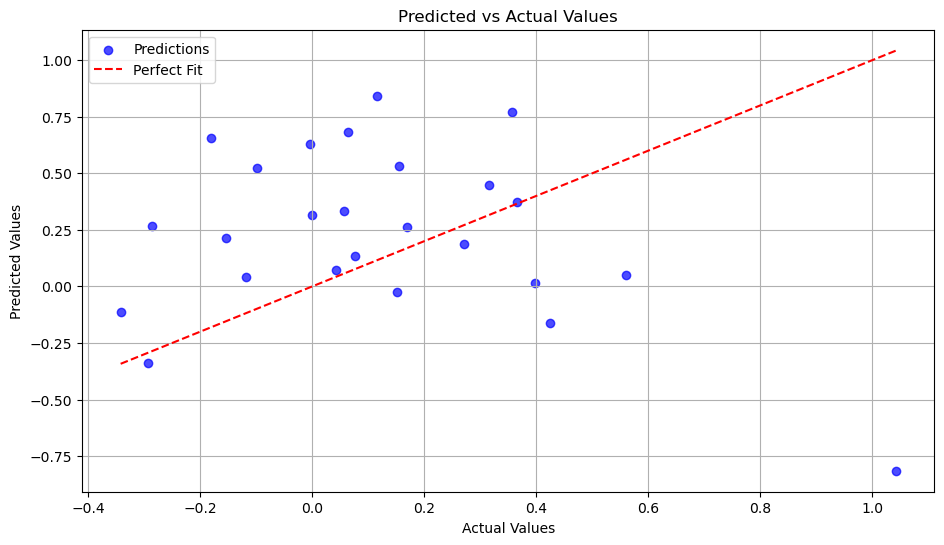

In [53]:
plt.figure(figsize=(11, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Predictions